In [24]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [25]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [26]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [27]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/train_bg.npy')
np_sig_SR = np.load('./data/train_sig.npy')
test_data = np.load('./data/test_data.npy')


np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

12

In [28]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


In [29]:
def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [30]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [31]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [32]:
classifier = classifier_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

In [33]:

def train(s,b,iteration,ratio):
    
    fpr_list = []
    tpr_list = []
    threshold_list = []
    auc_list = []
    sig_SR = sample_data(np_sig_SR,s)
    bg_SR = sample_data(np_bg_SR,b)
    sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
    sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #put label 1 for real

    real_df = pd.DataFrame(sampleA , columns =['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','tau32j1','tau32j2','mjj','sb','rf'])
    real_forGen = real_df.drop(['tau32j1', 'tau32j2'], axis=1)
    realG= real_forGen.to_numpy()
    print(realG.shape)
    generated_data = generate_gan(gen_model,realG[:,0:10])
    generated_data2 = generate_gan(gen_model,realG[:,0:10])
    generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
    generated_data_labeled  = np.copy(generated_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)
    sampleB= sample_data(generated_data_labeled,s+b) # generated data
    sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1)
    dataset = np.concatenate((realG,sampleB),axis=0)
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) #rf label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label
    
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=50, batch_size=128,validation_data=(x_val,y_val),callbacks=[es])
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(thresholds)
    auc_list.append(auc_value)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')
    print(auc_value)
    print(auc_list)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    np.save('./Results/Classifier/tpr/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_list),allow_pickle = True)
    np.save('./Results/Classifier/fpr/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_list),allow_pickle = True)
    np.save('./Results/Classifier/th/threshold_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(threshold_list),allow_pickle = True)
    np.save('./Results/Classifier/auc/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_list),allow_pickle = True)
    

In [36]:

sb_ratio1 = [0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
           ]
sb_ratio2 = [ 0.04641589, 0.1       , 0.21544347, 0.46415888, 1.   ]

___
(100100, 12)
Train on 160160 samples, validate on 40040 samples
Epoch 1/50
160160/160160 [==============================] - 7s 41us/sample - loss: 0.7892 - tp: 46478.0000 - fp: 43832.0000 - tn: 36454.0000 - fn: 33396.0000 - accuracy: 0.5178 - precision: 0.5146 - recall: 0.5819 - auc: 0.5192 - val_loss: 0.6896 - val_tp: 16531.0000 - val_fp: 14920.0000 - val_tn: 4894.0000 - val_fn: 3695.0000 - val_accuracy: 0.5351 - val_precision: 0.5256 - val_recall: 0.8173 - val_auc: 0.5419
Epoch 2/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6913 - tp: 52753.0000 - fp: 48318.0000 - tn: 31968.0000 - fn: 27121.0000 - accuracy: 0.5290 - precision: 0.5219 - recall: 0.6605 - auc: 0.5403 - val_loss: 0.6878 - val_tp: 14225.0000 - val_fp: 12503.0000 - val_tn: 7311.0000 - val_fn: 6001.0000 - val_accuracy: 0.5379 - val_precision: 0.5322 - val_recall: 0.7033 - val_auc: 0.5582
Epoch 3/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6898 - tp: 51943.

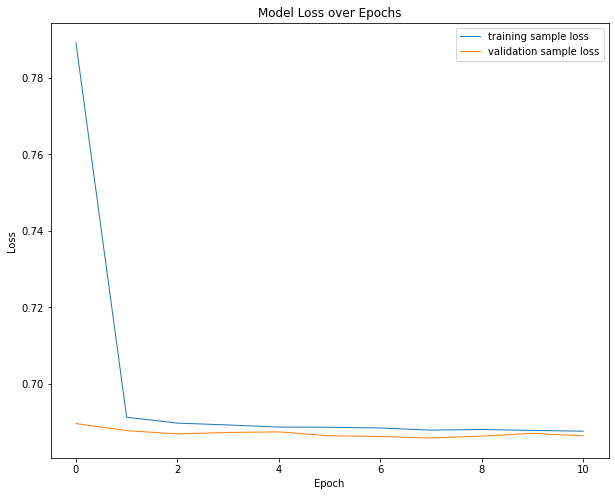

0.42475682313333335
[0.42475682313333335]
(100100, 12)
Train on 160160 samples, validate on 40040 samples
Epoch 1/50
160160/160160 [==============================] - 6s 40us/sample - loss: 0.7798 - tp: 44829.0000 - fp: 41438.0000 - tn: 38848.0000 - fn: 35045.0000 - accuracy: 0.5225 - precision: 0.5197 - recall: 0.5612 - auc: 0.5265 - val_loss: 0.6880 - val_tp: 13420.0000 - val_fp: 11681.0000 - val_tn: 8133.0000 - val_fn: 6806.0000 - val_accuracy: 0.5383 - val_precision: 0.5346 - val_recall: 0.6635 - val_auc: 0.5603
Epoch 2/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6895 - tp: 52506.0000 - fp: 47184.0000 - tn: 33102.0000 - fn: 27368.0000 - accuracy: 0.5345 - precision: 0.5267 - recall: 0.6574 - auc: 0.5502 - val_loss: 0.6879 - val_tp: 11033.0000 - val_fp: 9316.0000 - val_tn: 10498.0000 - val_fn: 9193.0000 - val_accuracy: 0.5377 - val_precision: 0.5422 - val_recall: 0.5455 - val_auc: 0.5585
Epoch 3/50
160160/160160 [==============================] - 5s 2

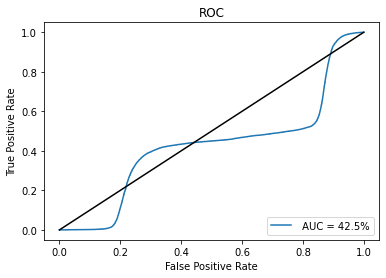

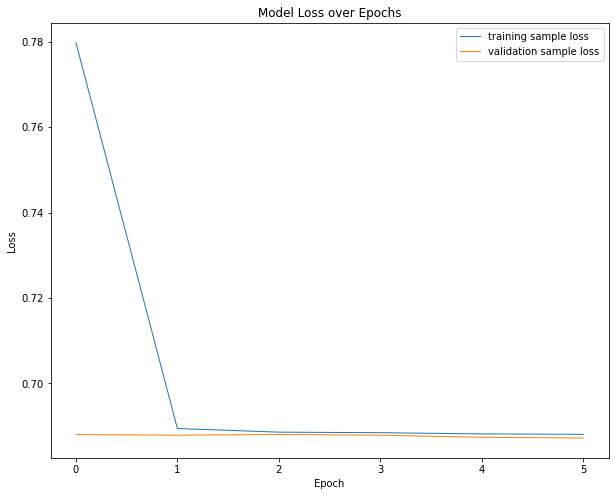

0.4070491283333334
[0.4070491283333334]
(100100, 12)
Train on 160160 samples, validate on 40040 samples
Epoch 1/50
160160/160160 [==============================] - 7s 42us/sample - loss: 0.7828 - tp: 48624.0000 - fp: 46469.0000 - tn: 33817.0000 - fn: 31250.0000 - accuracy: 0.5147 - precision: 0.5113 - recall: 0.6088 - auc: 0.5162 - val_loss: 0.6908 - val_tp: 15338.0000 - val_fp: 14005.0000 - val_tn: 5809.0000 - val_fn: 4888.0000 - val_accuracy: 0.5281 - val_precision: 0.5227 - val_recall: 0.7583 - val_auc: 0.5445
Epoch 2/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6922 - tp: 52316.0000 - fp: 48752.0000 - tn: 31534.0000 - fn: 27558.0000 - accuracy: 0.5235 - precision: 0.5176 - recall: 0.6550 - auc: 0.5328 - val_loss: 0.6895 - val_tp: 13621.0000 - val_fp: 12080.0000 - val_tn: 7734.0000 - val_fn: 6605.0000 - val_accuracy: 0.5333 - val_precision: 0.5300 - val_recall: 0.6734 - val_auc: 0.5518
Epoch 3/50
160160/160160 [==============================] - 5s 29u

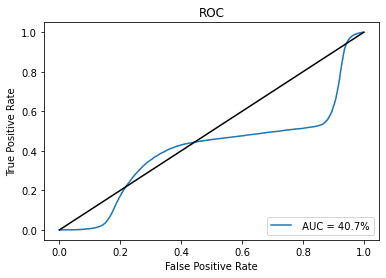

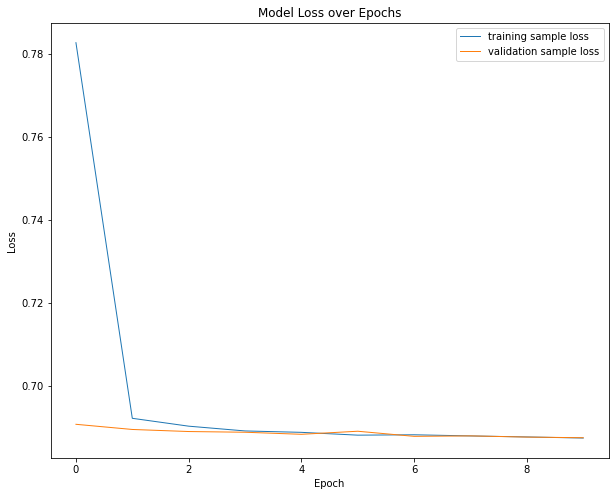

0.4047971660666667
[0.4047971660666667]
(100100, 12)
Train on 160160 samples, validate on 40040 samples
Epoch 1/50
160160/160160 [==============================] - 7s 42us/sample - loss: 0.9148 - tp: 51992.0000 - fp: 51630.0000 - tn: 28656.0000 - fn: 27882.0000 - accuracy: 0.5035 - precision: 0.5017 - recall: 0.6509 - auc: 0.5069 - val_loss: 0.6931 - val_tp: 20226.0000 - val_fp: 19814.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6939 - tp: 36428.0000 - fp: 36454.0000 - tn: 43832.0000 - fn: 43446.0000 - accuracy: 0.5011 - precision: 0.4998 - recall: 0.4561 - auc: 0.5001 - val_loss: 0.6932 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 19814.0000 - val_fn: 20226.0000 - val_accuracy: 0.4949 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/50
160160/160160 [============================

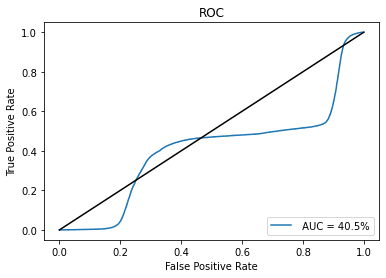

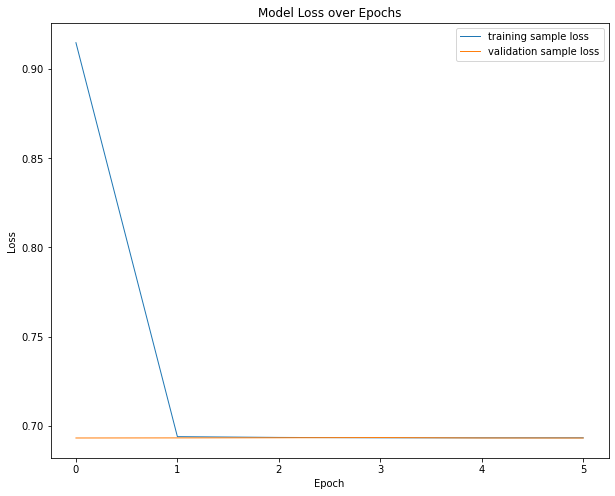

0.5
[0.5]
(100100, 12)
Train on 160160 samples, validate on 40040 samples
Epoch 1/50
160160/160160 [==============================] - 6s 40us/sample - loss: 0.8288 - tp: 42840.0000 - fp: 40671.0000 - tn: 39615.0000 - fn: 37034.0000 - accuracy: 0.5148 - precision: 0.5130 - recall: 0.5363 - auc: 0.5171 - val_loss: 0.6889 - val_tp: 15431.0000 - val_fp: 13857.0000 - val_tn: 5957.0000 - val_fn: 4795.0000 - val_accuracy: 0.5342 - val_precision: 0.5269 - val_recall: 0.7629 - val_auc: 0.5562
Epoch 2/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6906 - tp: 51103.0000 - fp: 46758.0000 - tn: 33528.0000 - fn: 28771.0000 - accuracy: 0.5284 - precision: 0.5222 - recall: 0.6398 - auc: 0.5413 - val_loss: 0.6879 - val_tp: 14664.0000 - val_fp: 12945.0000 - val_tn: 6869.0000 - val_fn: 5562.0000 - val_accuracy: 0.5378 - val_precision: 0.5311 - val_recall: 0.7250 - val_auc: 0.5611
Epoch 3/50
160160/160160 [==============================] - 5s 29us/sample - loss: 0.6895 - tp: 

In [ ]:
for i in sb_ratio1:
    signal = (np.round(i * 100000))
    bg = (np.round((1 - i) * 100000))
    #print(signal)
    #print(bg)
    #print(signal+bg)
    
    
    print('___')
    for j in range(50):
        train(signal.astype(int),signal.astype(int)+bg.astype(int),j,i)
        
  